# Class 11: Numerical Integration

CBE 20258. Numerical and Statistical Analysis. Spring 2020.

&#169; University of Notre Dame

**Reference**: Chapters 15 and 16 in McClarren (2018). There are two copies in reserve at the library.

In [1]:
# load libraries
from scipy import integrate
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon

## Class 11: Learning Objectives

After studying this notebook, completing the activities, and asking questions in class, you should be able to:
* Draw a sketch to illustrate the main idea behind midpoint, trapezoid and Simpson rules, or identify the rule name from a sketch
* Derive the error order for midpoint and trapezoid rules from a Taylor series expansion
* Approximate a definite integral using Newton-Cotes formulas or quadrature rules in Python
* Quickly determine the number of points to integrate a given polynomial exactly with Gauss quadrature

## 11a. Motivating Example and Main Idea

Often in engineering, we want or must numerically approximate definite integrals.

### 11a-i. Example: Integrate Normal Distribution

In a few weeks, we will learn how to model random phenomena with probability distributions. Often, standardized test scores follow a normal distribution, a.k.a.,  Gaussian distribution or bell curve.

![sat](sat.jpg)

These data (which I found online and did not verify... we are just using this as an example) suggest the average SAT score was 1500 with a standard deviation of 250 points. Briefly, mean is the average and standard deviation measures spread. We will mathematically define these quantifies in a few class sessions.

Imagine we randomly select a student that took the SAT. What is the probability they received a score of $a = 1800$ points? By assuming the SAT scores are normally distributed, we can express this probability as follows:

$$P(X = a) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}}$$

This is known as the **probability density function** (PDF). $\mu$ is the mean and $\sigma$ is the standard deviation. For our SAT data, $\mu = 1500$ and $\sigma = 250$. $X$ is the outcome of the random experiment, which, for this example, is the SAT score of a randomly selected person. $X$ is capital because it is a random variable. We will formally study all of this in a few weeks. I am sharing now just to help build comfort.

For convenience, I will use $p(x)$ as shorthand for the PDF:

$$
p(x) = \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}}
$$

Below is a Python function to evaluate the probability density function. Notice I created a lambda function `my_p` with the mean and standard deviation for the SAT example.

In [2]:
def normal_pdf(x,mean,stdev):
    '''Probability density function (PDF) for normal distribution
    Arg:
        x: outcome value
        mean: mean
        stdev: standard deviation
    
    Return: probability    
    '''
    
    assert stdev > 0.0
    
    var = stdev**2
    
    return (1/np.sqrt(2*np.pi*var)) * np.exp(-(x - mean)**2 / 2 / var)

# Integrate numerically. We'll learn the details of how this works later in the class.

my_p = lambda x: normal_pdf(x, mean=1500, stdev=250)

Let's calculate the probability a randomly selected test taker scored 1800. We just need to evaluate $p(1800)$.

In [3]:
my_p(1800)

0.0007767442199328519

0.07% is a very small number! Often, we really want to ask *what is that probability a random test taker scored $a$ or less?* We can write this as a **definite integral**:

$$
P(X \leq a) = \int_{-\infty}^{a} p(x) dx =  \int_{-\infty}^{a} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}} dx
$$

We are integrating the probability density function $p(x)$ from the lowest possible value, $-\infty$, to $a$. *Wait, how do you get a negative SAT score?!?!* This is a great practical point. We'll learn in a few weeks that the normal distribution allows for random variable outcomes between $-\infty$ and $\infty$. But because the probability of really extreme scores is so low, we can still use the normal distribution for many problems, such as the SAT, with valid outcomes over only a finite range, e.g., 0 to 2400.

You decided to trust me on this point, although you are still a little skeptical. So, just substitute $a=1800$, $\mu = 1500$ and $\sigma = 250$ and integrate? The integral looks really hard. I hope it is not on the next exam!

The integral above actually does not have an analytic solution except for some special cases. (You can show analytically that integrating from $-\infty$ and $\infty$ gives 1.) We need to integrate numerically, making it a great motivating example for this class on **numeric integration**.

We first replaced the $-\infty$ with $-10000$,

$$
P(X \leq a) \approx \int_{-10000}^{a} \frac{1}{\sqrt{2 \pi \sigma^2}} e^{- \frac{(x-\mu)^2}{2 \sigma^2}} dx
$$

and then integrated numerically using ``scipy.integrate.quad``:

In [4]:
value, tol = integrate.quad(my_p,-10000,1800)
print("Integral value = ",value)
print("Integration tolerance (approximate error) = ",tol)

Integral value =  0.8849303297782916
Integration tolerance (approximate error) =  6.5792911954510715e-12


We can see that if we randomly selected an SAT test taker, there is a 88.5% probably they scored 1800 or less. Alternately, if someone scores 1800, we say they are in the 88th percentile. In the rest of this class, we will learn what ``quad`` and other ``scipy`` functions do "under the hood".

### 11a-ii. Example: Let's Revisit that Unbounded Assumption

The normal distribution assumes the random variable can have outcomes between $-\infty$ to $\infty$. But, for this year, valid SAT scores were between 0 and 2400. What is the error caused by approximating SAT scores with a normal distribution?

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Using the normal distribution, compute the probability of a score between -10,000 and 0. Store your answer in the Python float <tt>ans_aii1</tt>.
</div>

In [5]:
### BEGIN SOLUTION

value, tol = integrate.quad(my_p,-10000,0)
print("Integral value = ",value)
print("Integration tolerance = ",tol)

ans_aii1 = value

### END SOLUTION

Integral value =  9.865965575048534e-10
Integration tolerance =  1.874391547379387e-09


In [6]:
### BEGIN HIDDEN TESTS

assert ans_aii1 < 1E-8, "This probability should be really small."

### END HIDDEN TESTS

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Using the normal distribution, compute the probability of a score between 2400 and 10,000. Store your answer in the Python float <tt>ans_aii2</tt>.
</div>

In [7]:
### BEGIN SOLUTION

value, tol = integrate.quad(my_p,2400,10000)
print("Integral value = ",value)
print("Integration tolerance = ",tol)

ans_aii2 = value

### END SOLUTION

Integral value =  0.00015910859015752824
Integration tolerance =  9.36189270348194e-10


In [8]:
### BEGIN HIDDEN TESTS

assert ans_aii2 < 1E-3, "Your answer is too large"
assert ans_aii2 > 1E-5, "Your answer is too small"

### END HIDDEN TESTS

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Write a sentence to defend or refute our choice to model SAT scores with a normal distribution.
</div>

**Home Activity Answer:**

### 12a-iii. Main Idea

We will approximate an integral by a sum with a finite number of terms:
$$\int\limits_a^b f(x)\,dx \approx \sum_{l=0}^{L}w_l f(x_l).$$

The function $f( )$ is evaluated at locations (nodes) $x_l$. Each function evaluation is multiplied by weight $w_l$ and then summed.

This approach is known as a **quadrature** rule or simply **numerical integration**. We will focus on two broad families of methods: **Newton-Cotes formulas** and **Gaussian quadrature rules**.

**Connection back to Calculus II**: Writing an integral as a finite sum is analogous to the definition of an integral as a Riemann sum.  Therefore, just as in finite difference derivatives, we use finite mathematics to approximate
the infinitesimals of calculus.

## 11b. Newton-Cotes Formulas

This is a broad family of numerical methods that follow the same general recipe:
1. Fit a polynomial through the function evaluations.
2. Integrate the polynomial approximation exactly.

We will not discuss the general theory of Newton-Cotes formulas, but instead focus on three important methods commonly used.

### 11b-i. Midpoint Rule

In the midpoint rule, we approximate the integral by the value of the function in the middle of the range of integration times the length of the region. This simple formula is
$$I_{midpoint} = h\, f\!\left(\frac{a+b}{2}\right) \approx \int\limits_{a}^b f(x)\,dx,$$
where $h = b-a$. We can demonstrate this with a **graphical example**:

$$
f(x) = (x-3) (x-5) (x-7) + 100
$$

Integral estimate =  660.0


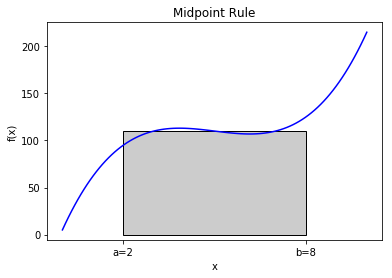

In [9]:
# define and plot function
f = lambda x: (x-3)*(x-5)*(x-7)+110
x = np.linspace(0,10,100)
plt.plot(x,f(x),label="f(x)",color="blue")

# get current axes
ax = plt.gca()

## draw polygon
# define a and b
a = 2
b = 8

# evaluate midpoint
midpoint = 0.5*(a+b)
fmid = f(midpoint)

# estimate integral
Imid = (b-a)*fmid
print("Integral estimate = ",Imid)

# draw rectangle
verts = [(a,0),(a,fmid), (b,fmid),(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))

# add labels
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Midpoint Rule")
plt.show()

The resulting approximation is not terrible, but there are clearly parts of the function where the rectangle does not match the function well. We can do better than a rectangle that approximates the function as flat. 

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Copy the code from above to the cell below. Then modify the copied code to integrate $g(x) = x(1-\sin(x))$ from $a=3$ to $b=7$ using the midpoint rule. Save the numeric approximation in the Python variable <tt>ans_bi</tt>. Hint: Use the function <tt>np.sin</tt>.
</div>

Integral estimate =  39.17848549326277


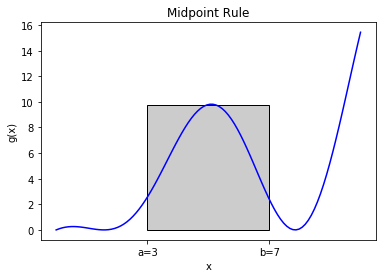

In [10]:
### BEGIN SOLUTION
# define and plot function
g = lambda x: x*(1-np.sin(x))
x = np.linspace(0,10,100)
plt.plot(x,g(x),label="f(x)",color="blue")

# get current axes
ax = plt.gca()

## draw polygon
# define a and b
a = 3
b = 7

# evaluate midpoint
midpoint = 0.5*(a+b)
fmid = g(midpoint)

# estimate integral
Imid = (b-a)*fmid
print("Integral estimate = ",Imid)

ans_bi = Imid

# draw rectangle
verts = [(a,0),(a,fmid), (b,fmid),(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))

# add labels
plt.xlabel("x")
plt.ylabel("g(x)")
plt.title("Midpoint Rule")
plt.show()

### END SOLUTION

In [11]:
### BEGIN HIDDEN TESTS
secret_ans = 39.17848549326277

assert ans_bi <= secret_ans + 1E-4, "Your answer is too large."
assert ans_bi >= secret_ans - 1E-4, "Your answer is too small."
### END HIDDEN TESTS

### 12b-ii. Trapezoid Rule

#### Main Idea and Graphical Example

Instead of approximating with a rectangle (midpoint rule), use a trapezoid:
1. Fit a line between $a$ and $b$. This is a polynomial (linear) approximation to $f(x)$.
2. Integrate the polynomial exactly

The formula for this is
$$ I_\mathrm{trap} \equiv \frac{h}{2}(f(a) + f(b)) \approx \int\limits_a^b f(x)\,dx,$$ where
$h = b - a.$ Here is a graphical example on a polynomial function.

Integral estimate =  660.0


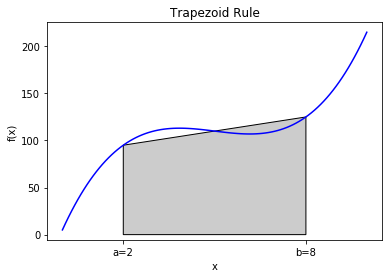

In [12]:
# define and plot function
f = lambda x: (x-3)*(x-5)*(x-7)+110
x = np.linspace(0,10,100)
plt.plot(x,f(x),label="f(x)",color="blue")

# get current axes
ax = plt.gca()

# draw polygon
a = 2
b = 8
verts = [(a,0),(a,f(a)), (b,f(b)),(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))

# estimate integral
Itrap = (b-a)/2*(f(a) + f(b))
print("Integral estimate = ",Itrap)

# add labels
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Trapezoid Rule")
plt.show()

You can see in the figure that the approximation is not exact because the trapezoid does not exactly follow the function, but if $a$ and $b$ are close enough together it should give a good approximation because any well-behaved function can be approximated linearly over a narrow enough domain.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Copy the code from above to the cell below. Then modify the copied code to integrate $g(x) = x(1-\sin(x))$ from $a=3$ to $b=7$ using the trapezoid rule. Save the numeric approximation in the Python variable <tt>ans_bii1</tt>.
</div>

Integral estimate =  9.955467569577749


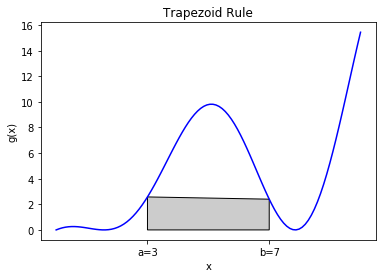

In [13]:
### BEGIN HIDDEN SOLUTION
# define and plot function
g = lambda x: x*(1-np.sin(x))
x = np.linspace(0,10,100)
plt.plot(x,g(x),label="g(x)",color="blue")

# get current axes
ax = plt.gca()

# draw polygon
a = 3
b = 7
verts = [(a,0),(a,g(a)), (b,g(b)),(b,0)]
poly = Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))

# estimate integral
Itrap = (b-a)/2*(g(a) + g(b))
print("Integral estimate = ",Itrap)
ans_bii1 = Itrap

# add labels
plt.xlabel("x")
plt.ylabel("g(x)")
plt.title("Trapezoid Rule")
plt.show()

### END HIDDEN SOLUTION

In [14]:
### BEGIN HIDDEN TESTS
secret_ans = 9.955467569577749

assert ans_bii1 <= secret_ans + 1E-4, "Your answer is too large."
assert ans_bii1 >= secret_ans - 1E-4, "Your answer is too small."
### END HIDDEN TESTS

#### Trapezoid Rule with Multiple Pieces

That leads to a variation to the trapezoid rule (and any other rule for that matter).  We can break up the domain $[a,b]$ into many smaller domains and integrate each of these.  Here's an example where we break $[a,b]$ into 4 pieces:

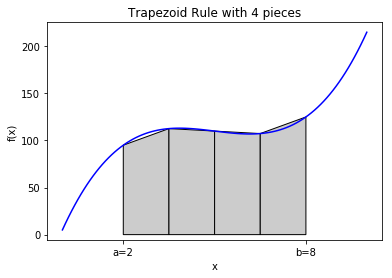

Integral estimate with 4 pieces =  660.0


In [15]:
#graphical example of 4 pieces

# define polynomial and plot
f = lambda x: (x-3)*(x-5)*(x-7)+110
x = np.linspace(0,10,100)
plt.plot(x,f(x),label="f(x)",color="blue")
ax = plt.gca()
a = 2
b = 8
h = b - a
N = 4

# draw trapezoids and integrate
Itrap = 0.0
for i in range(N):
    xleft = a+i*h/N
    fleft = f(xleft)
    xright = a+(i+1)*h/N
    fright = f(xright)
    
    Itrap += (h/N/2)*(fleft + fright)
    
    verts = [(xleft,0),(xleft,fleft), (xright,fright),(xright,0)]
    poly = Polygon(verts, facecolor='0.8', edgecolor='k')
    ax.add_patch(poly)
    
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Trapezoid Rule with "+str(N)+" pieces")
plt.show()

print("Integral estimate with",N,"pieces = ",Itrap)

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> <b>Home Activity</b>: Copy the code from above to the cell below. Then modify the copied code to integrate $g(x) = x(1-\sin(x))$ from $a=3$ to $b=7$ using the trapezoid rule with $N$ pieces. Per WolframaAlpha, the answer is 27.7314266795455... Determine the minimum number of pieces needed such that approximation, when rounded, matches the exact answer to one decimal place. Store your answer as an integer in <tt>ans_bii2</tt>.
</div>

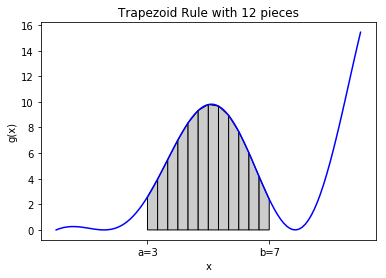

Integral estimate with 12 pieces =  27.650117867008063


In [16]:
### BEGIN SOLUTION
#graphical example of 4 pieces
g = lambda x: x*(1-np.sin(x))
x = np.linspace(0,10,100)
plt.plot(x,g(x),label="g(x)",color="blue")
ax = plt.gca()
a = 3
b = 7
h = b - a
N = 12

#graphical example of 4 pieces

# draw trapezoids and integrate
Itrap = 0.0
for i in range(N):
    xleft = a+i*h/N
    fleft = g(xleft)
    xright = a+(i+1)*h/N
    fright = g(xright)
    
    Itrap += (h/N/2)*(fleft + fright)
    
    verts = [(xleft,0),(xleft,fleft), (xright,fright),(xright,0)]
    poly = Polygon(verts, facecolor='0.8', edgecolor='k')
    ax.add_patch(poly)
    
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))
plt.xlabel("x")
plt.ylabel("g(x)")
plt.title("Trapezoid Rule with "+str(N)+" pieces")
plt.show()

print("Integral estimate with",N,"pieces = ",Itrap)

ans_bii2 = 12
### END SOLUTION

In [17]:
### BEGIN HIDDEN TESTS
assert type(ans_bii2) is int, "Answer should be an integer"

assert ans_bii2 == 12, "Try N=11, N=12, and N=13."
### END HIDDEN TESTS

#### General Purpose Function and Test Case

We can write a trapezoid rule function that will take in a function, $a$, $b$, and the number of pieces and perform this integration. Also, because the right side of each piece is the left side of the next piece, if we're clever we can only evaluate the function once $N+1$ times where $N$ is the number of pieces.

The following function implements the trapezoid rule, and will produce a graph of the approximation when the parameter <tt>graph</tt> is set to true.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Study the code below. Write at least two questions to ask your neighbor during class.
</div>

Question 1:

Question 2:

In [18]:
def trapezoid(f, a, b, pieces, graph=False):
    """Find the integral of the function f between a and b using pieces trapezoids
    Args:
        f: function to integrate
        a: lower bound of integral
        b: upper bound of integral
        pieces: number of pieces to chop [a,b] into
        
    Returns:
        estimate of integral
    """
    # set integral sum to zero
    integral = 0
    
    # calculate total width
    h = b - a
    
    # plot true function
    if (graph):
        x = np.linspace(a,b,100)
        plt.plot(x,f(x),label="f(x)",color="blue")
        ax = plt.gca()
    
    # initialize the left function evaluation
    fa = f(a)
    
    for i in range(pieces):
        # evaluate the function at the right end of the current piece
        fb = f(a + (i+1)*h/pieces)
        
        # add to integral
        integral += 0.5*h/pieces*(fa + fb)
        
        # plot the current piece
        if (graph):
            verts = [(a+i*h/pieces,0),(a+i*h/pieces,fa), (a+(i+1)*h/pieces,fb),(a+(i+1)*h/pieces,0)]
            poly = Polygon(verts, facecolor='0.9', edgecolor='k')
            ax.add_patch(poly)
            
        # now make the left function evaluation the right for the next step
        fa = fb
    
    # label plot
    if (graph):
        ax.set_xticks((a,b))
        ax.set_xticklabels(('a='+str(a),'b='+str(b)))
        plt.xlabel("x")
        plt.ylabel("f(x)")
        if (pieces > 1):
            plt.title("Trapezoid Rule with " + str(pieces) + " pieces")
        else:
            plt.title("Trapezoid Rule with " + str(pieces) + " piece")
        plt.show()
    return integral

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Complete the activity on the handout.
</div>

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Imagine we call <tt>trapezoid</tt> with <tt>pieces = 10</tt>. How many times will <tt>f</tt> be evaluated? Store your answer in Python integer <tt>ans_bii3</tt>.
</div>

In [19]:
ans_bii3 = 0

### BEGIN SOLUTION
ans_bii3 = 11
### END SOLUTION

In [20]:
### BEGIN HIDDEN TESTS
secret_bii3 = 11

assert type(ans_bii3) is int, "Your answer should be an integer."

assert ans_bii3 == secret_bii3, "Carefully examine the code and read the description of the trapezoid rule."
### END HIDDEN TESTS

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Run the code below.

Let's test this method on a function that we know the integral of $$\int\limits_0^\pi \sin x\,dx = 2.$$

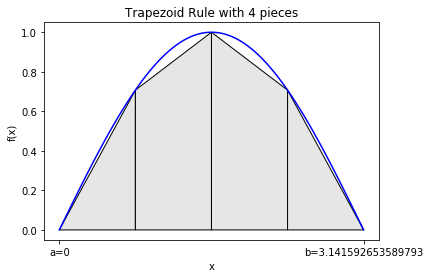

Estimate is 1.8961188979370398 while the actual value is 2


In [21]:
integral_estimate = trapezoid(np.sin,0,np.pi,pieces=4,graph=True)
print("Estimate is",integral_estimate,"while the actual value is 2")

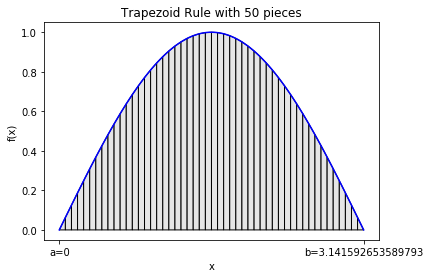

Estimate is 1.999341983076262 while the actual value is 2


In [22]:
integral_estimate = trapezoid(np.sin,0,np.pi,pieces=50,graph=True)
print("Estimate is",integral_estimate,"while the actual value is 2")

#### Error Analysis

How does the error change as we increase the number pieces (i.e., decrease the step size $h$)?

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Run the code below.

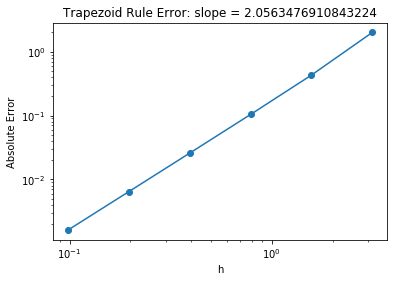

In [23]:
pieces = 2**np.arange(0,6)
error = np.zeros(6)
count = 0
for p in pieces:
    error[count] = np.fabs(trapezoid(np.sin,0,np.pi,pieces=p,graph=False) - 2.0)
    count += 1
h = np.pi/pieces
plt.loglog(h,error,'o-')
slope = (np.log(error[0]) - np.log(error[-1]))/(np.log(h[0]) - np.log(h[-1]) )
plt.title("Trapezoid Rule Error: slope = " + str(slope))
plt.xlabel("h")
plt.ylabel("Absolute Error")
plt.show()

Similar to what we did for finite difference derivatives, we can plot the error versus number of pieces on a log-log scale. The error in the trapezoid rule that we observe is second-order in $h$, because the slope of the error on the log-log scale is 2.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Go through the derivation below on the chalkboard.
</div>

**We will now use a Taylor series to show why the slope is 2.**

We can see that this is the expected error in the estimate by looking at the linear approximation to a function around $x = a$:
$$f(x) = f(a) + (x-a) f'(a) + \frac{(x-a)^2}{2} f''(a) + O((x-a)^3).$$
We can approximate the derivative using a forward difference:
$$f'(a) \approx \frac{f(b) - f(a)}{h} + O(h),$$
where $h = b-a$. Now the integral of $f(x)$ from $a$ to $b$ becomes
$$\int \limits_a^b f(x)\,dx = h f(a) + \int\limits_a^b (x-a) f'(a)\,dx +\int\limits_a^b \frac{(x-a)^2}{2} f''(a)\,dx + O(h^4).$$
The integral $$\int\limits_a^b (x-a) f'(a) dx = \frac{(b-a)^2}{2}f'(a) = \frac{h^2}{2}\left(\frac{f(b) - f(a)}{h} + O(h)\right)
= \frac{h}{2}\left(f(b)-f(a)\right) + O(h^3).$$
Additionally,
$$\int\limits_a^b \frac{(x-a)^2}{2} f''(a)\,dx = -\frac{h^3}{6} f''(a) = O(h^3).$$
When we plug this into the original integral we get
$$\int \limits_a^b f(x)\,dx = \frac{h}{2} (f(a) + f(b)) + O(h^3).$$
This says that error in one piece of the trapezoid rule is third-order accurate, which means the error can be written as $C h^3 + O(h^4)$.  However, when we break the interval into $N$ pieces, each of size $h = (b-a)/N$, the error terms add and each piece has its own constant so that
$$\sum_{i=1}^N C_i h^3 \leq N h^3 C_\mathrm{max} = (b-a)C_\mathrm{max} h^2,$$
where $C_\mathrm{max}$ is the maximum value of $|C_i|$.  Therefore, the error in the sum of trapezoid rules decreases as $h^2$, which we observed above.  This analysis can be extended to show that the error terms in the trapezoid rule only have even powers of $h$: $$\mathrm{Error} = C_2 h^2 + C_4 h^4 + \dots$$

### 12b-iii. Simpson's Rule

We will now take the idea of the trapezoid rule a step further by **fitting a parabola** between three points: $a$, $b$, and $(a+b)/2$.  The formula for this is
$$ I_\mathrm{Simpson} \equiv \frac{h}{6}\left(f(a) + 4 f\left(a + \frac{h}{2}\right) + f(b)\right) \approx \int\limits_a^b f(x)\,dx,$$ where
$h = b - a.$

Footnote: This is sometimes called Simpsions 1/3 rule.

#### Quadratic Interpolation

Before examining Simpson's rule, we need to quickly discuss quadratic interpolation. Let's say I have evaluated the function $g(x)$ at three points: $a_1$, $a_2$ and $a_3$. I now want to approximate $g(x)$ and any point $x$ using **quadratic interpolation**.

$$
g(x) \approx \frac{(x-a_2)(x-a_3)}{(a_1 - a_2)(a_1 - a_3)} g(a_1) + \frac{(x-a_1)(x-a_3)}{(a_2 - a_1)(a_2 - a_3)} g(a_2) + \frac{(x-a_1)(x-a_2)}{(a_3 - a_1)(a_3 - a_2)} g(a_3)
$$

In [24]:
def quadratic_interp(a,f,x):
    """Compute at quadratic interpolant
    Args:
        a: array of the 3 points
        f: array of the value of f(a) at the 3 points
        x: point to interpolate at
    Returns:
        The value of the linear interpolant at x
    """
    answer = (x-a[1])*(x-a[2])/(a[0]-a[1])/(a[0]-a[2])*f[0] 
    answer += (x-a[0])*(x-a[2])/(a[1]-a[0])/(a[1]-a[2])*f[1] 
    answer += (x-a[0])*(x-a[1])/(a[2]-a[0])/(a[2]-a[1])*f[2] 
    return answer

Let's return to the example $f(x) = (x-3)(x-5)(x-7)+110$ to test our function.

In [25]:
f = lambda x: (x-3)*(x-5)*(x-7)+110

Now let's test our quadratic interpolation formula. We'll choose $x=0$, $x=1$, and $x=2$ as the three node locations. We'll start by evaluating our function $f(x)$ at these three points.

In [26]:
x_nodes = np.array([0.0, 1.0, 2.0])
f_nodes = np.zeros(len(x_nodes))

# loop over elements of x_node
for i in range(len(x_nodes)):
    # evaluate f() and store answer in f_nodes
    f_nodes[i] = f(x_nodes[i])
    # print to screen
    print("f(",x_nodes[i],") =",f_nodes[i])

f( 0.0 ) = 5.0
f( 1.0 ) = 62.0
f( 2.0 ) = 95.0


Now let's evaluate our interpolation function $g(x)$ at these three points:

In [27]:
quadratic_interp(x_nodes, f_nodes, 0.25)

21.5

In [28]:
for i in x_nodes:
    print("g(",i,") =",quadratic_interp(x_nodes, f_nodes, i))

g( 0.0 ) = 5.0
g( 1.0 ) = 62.0
g( 2.0 ) = 95.0


We see the quadratice interpolation $g(x)$ is exact at the three nodes. Please verify this makes sense based on the formula for $g(x)$.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Evaluate the original function $f(x)$ and the quadratic interpolation approximation $g(x)$ at $x=0.25$. Record your answer in <tt>f_b_iii</tt> and <tt>g_b_iii</tt>. Use the same nodes as the example, i.e., do not modify <tt>x_nodes</tt> and <tt>f_nodes</tt>.
</div>

In [29]:
### BEGIN SOLUTION
x_new = 0.25
f_b_iii = f(x_new)
g_b_iii = quadratic_interp(x_nodes, f_nodes, x_new)
print("f(",x_new,") =",f_b_iii)
print("g(",x_new,") =",g_b_iii)
### END SOLUTION

f( 0.25 ) = 21.828125
g( 0.25 ) = 21.5


In [30]:
### BEGIN HIDDEN TESTS
secret_f_b_iii = 21.828125
secret_g_b_iii = 21.5

assert np.abs(secret_f_b_iii - f_b_iii) < 1E-4, "Check your answer for f(0.25)"
assert np.abs(secret_g_b_iii - g_b_iii) < 1E-4, "Check your answer for g(0.25)"

### END HIDDEN TESTS

You should see the quadratic interpolant is a good approximation, but not perfect.

The code below graphically explores $g(x)$.

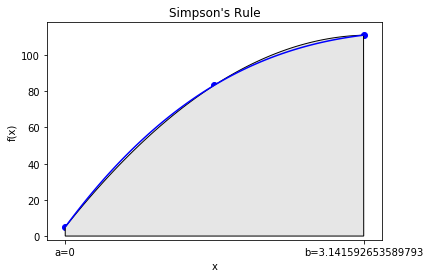

In [31]:
# plot true function in blue
a = 0
b = np.pi
x = np.linspace(a,b,100)
plt.plot(x,f(x),label="f(x)",color="blue")

# assemble nodes of three points, plot as circles
nodes = [a,0.5*(a+b),b]
fnodes = f(np.array([a,0.5*(a+b),b]))
plt.scatter(nodes, fnodes, marker='o',color='blue')

# plot polygone to visualize quadratic interpoation
ax = plt.gca()
ix = np.arange(a, b, 0.01)
iy = quadratic_interp(nodes,fnodes,ix)
verts = [(a,0)] + list(zip(ix,iy)) + [(b,0)]
poly = plt.Polygon(verts, facecolor='0.9', edgecolor='k')
ax.add_patch(poly)

# label axes
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))
plt.xlabel("x")
plt.ylabel("f(x)")
plt.title("Simpson's Rule")
plt.show()

We can see the quadratic function fits $f(x)$ really well. This is not that surprising, as $f(x)$ is a cubic.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Copy the code above to below. Adapt the copied code to explore $g(x) = x (1-\sin(x))$. Write a sentence to discuss the results.
</div>

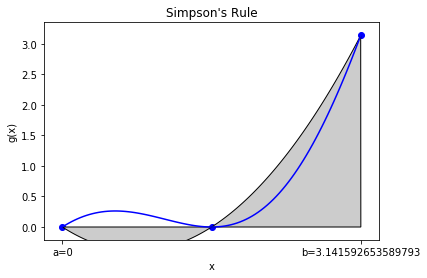

In [32]:
### BEGIN SOLUTION
f = lambda x: x*(1-np.sin(x))

# plot true function in blue
a = 0
b = np.pi
x = np.linspace(a,b,100)
plt.plot(x,f(x),label="f(x)",color="blue")

# assemble nodes of three points, plot as circles
nodes = [a,0.5*(a+b),b]
fnodes = f(np.array([a,0.5*(a+b),b]))
plt.scatter(nodes, fnodes, marker='o',color='blue')

# plot polygone to visualize quadratic interpoation
ax = plt.gca()
ix = np.arange(a, b, 0.01)
iy = quadratic_interp(nodes,fnodes,ix)
verts = [(a,0)] + list(zip(ix,iy)) + [(b,0)]
poly = plt.Polygon(verts, facecolor='0.8', edgecolor='k')
ax.add_patch(poly)

# label axes
ax.set_xticks((a,b))
ax.set_xticklabels(('a='+str(a),'b='+str(b)))
plt.xlabel("x")
plt.ylabel("g(x)")
plt.title("Simpson's Rule")
plt.show()
### END SOLUTION

**Home Activity Discussion:**

#### General Purpose Function and Test Case

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Study the code below. Write at least two questions to ask your neighbor during class.
</div>

In [33]:
def simpsons(f, a, b, pieces, graph=False):
    """Find the integral of the function f between a and b using Simpson's rule
    Args:
        f: function to integrate
        a: lower bound of integral
        b: upper bound of integral
        pieces: number of pieces to chop [a,b] into
        
    Returns:
        estimate of integral
    """
    
    # set integral counter to 0
    integral = 0
    
    # calculate total witdth
    h = b - a
    
    # compute and save 1/6
    one_sixth = 1.0/6.0
    
    # plot function
    if (graph):
        x = np.linspace(a,b,100)
        plt.plot(x,f(x),label="f(x)",color="blue")
        ax = plt.gca()
    
    #initialize the left function evaluation
    fa = f(a)
    for i in range(pieces):
        # evaluate the function at the right end of the piece
        fb = f(a + (i+1)*h/pieces)
        fmid = f(a + (i+0.5)*h/pieces)
        integral += one_sixth*h/pieces*(fa + 4*fmid + fb)
        
        # visualize piece
        if (graph):
            ix = np.arange(a+i*h/pieces, a+(i+1)*h/pieces, 0.001)
            iy = quadratic_interp(np.array([a+i*h/pieces,0.5*(a+(i+1)*h/pieces+ a+i*h/pieces),a+(i+1)*h/pieces]),
                                  np.array([fa,fmid,fb]),ix)
            verts = [(a+i*h/pieces,0)] + list(zip(ix,iy)) + [(a+(i+1)*h/pieces,0)]
            poly = plt.Polygon(verts, facecolor='0.9', edgecolor='k')
            ax.add_patch(poly)
        
        # now make the left function evaluation the right for the next step
        fa = fb
        
    # label plot    
    if (graph):
        ax.set_xticks((a,b))
        ax.set_xticklabels(('a='+str(a),'b='+str(b)))
        plt.xlabel("x")
        plt.ylabel("f(x)")
        plt.title("Simpsons Rule with " + str(pieces) + " pieces")
        plt.show()
    return integral

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Complete the activity on the handout.
</div>

We wrote a function. Now let's test it by approximating:

$$
\int_{0}^{\pi} \sin(x) dx
$$

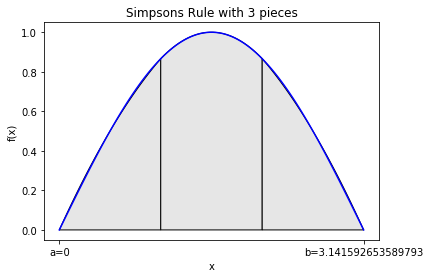

Estimate is 2.000863189673536 while the actual value is 2


In [34]:
integral_estimate = simpsons(np.sin,0,np.pi,pieces=3,graph=True)
print("Estimate is",integral_estimate,"while the actual value is 2")

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Recompute the integral estimate with 50 pieces. Store the answer in <tt>ans_biii_50</tt>.
</div>

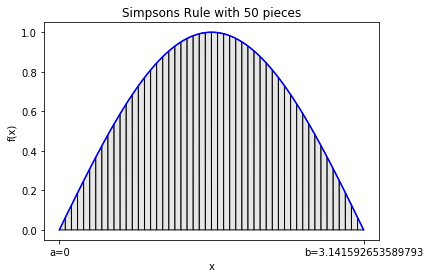

Estimate is 2.0000000108245035 Actual value is 2


In [35]:
### BEGIN SOLUTION
integral_estimate = simpsons(np.sin,0,np.pi,pieces=50,graph=True)
print("Estimate is",integral_estimate,"Actual value is 2")
ans_biii_50 = integral_estimate
### END SOLTUON

In [36]:
### BEGIN HIDDEN TESTS
assert ans_biii_50 <= 2 + 1E-6
assert ans_biii_50 >= 2 - 1E-6
### END HIDDEN TESTS

#### Error Analysis

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Run the code below.
</div>

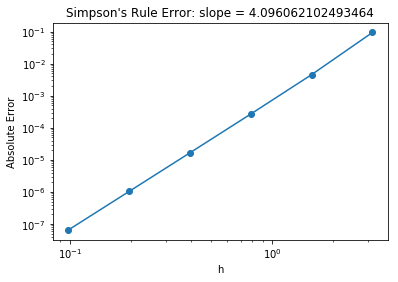

In [37]:
pieces = 2**np.arange(0,6)
error = np.zeros(6)
count = 0
for p in pieces:
    error[count] = np.fabs(simpsons(np.sin,0,np.pi,pieces=p,graph=False) - 2.0)
    count += 1
h = np.pi/pieces
plt.loglog(h,error,'o-')
slope = (np.log(error[0]) - np.log(error[-1]))/(np.log(h[0]) - np.log(h[-1]) )
plt.title("Simpson's Rule Error: slope = " + str(slope))
plt.xlabel("h")
plt.ylabel("Absolute Error")
plt.show()

Simpson's rule is fourth-order in the piece size. This means that every time I double the number of pieces the error goes down by a factor of $2^4 = 16$. 

#### Another Example: Approximating $\pi$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Run code below and discuss.
</div>


We can approximate $\pi$ with the following integral:

$$ \int\limits_0^1 4 \sqrt{1-x^2}\,dx = \pi$$

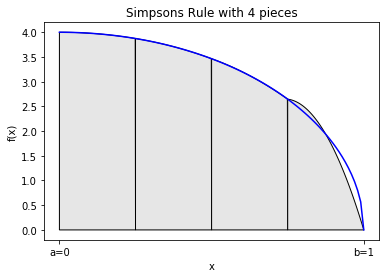

3.1211891697754175

In [38]:
integrand = lambda x: 4*np.sqrt(1-x**2)
simpsons(integrand,0,1,pieces = 4,graph=True) #actual value is 3.14159

Most of the error comes at $x=1$. This is because the derivative of $\sqrt{1-x^2}$ is singular at $x=1$, which makes it difficult to build an accurate polynomial approximation.

## 12c. Gauss Quadrature Rules

To recap, **Newton-Cotes formulas** approximate integrals by fitting the integrand with an interpolating polynomial and then integrating the polynomial exactly. In contrast, **Gauss quadrature** methods guarantees the **maximum accuracy** for a given number of points. Both Newton-Cotes and Gauss quadrature approximate integrals as a sum of function evaluations and weights:

$$\int\limits_a^b f(x)\,dx \approx \sum_{l=0}^{L}w_l f(x_l).$$

The "magic" of Gauss quadrature is selecting the weights $w_l$ and nodes (i.e., abscissas) $x_l$ to maximize accuracy. There are many different types of Gauss quadrature rules. We will focus our discussion on the **Gauss-Legendre** variety.

#### Integral Bounds Transformation

The Gauss-Legendre quadrature rule is for integrals of the form
$$\int\limits_{-1}^1 f(x)\,dx \approx \sum_{l=1}^L w_l f(x_l).$$
The integral does not need to be limited just to the range, $[-1,1]$, however. If we want to integrate $f(x)$ from $[a,b]$, we define a variable

$$x = \frac{a+b}{2} + \frac{b-a}{2}z, \qquad dx = \frac{b-a}{2} dz,$$ 


where $z \in [-1, 1]$. This makes the transformation

$$\int_a^b f(x)\,dx = \frac{b-a}{2} \int_{-1}^1 f\left(\frac{b-a}{2}z + \frac{a+b}{2}\right)\,dz.$$

#### Transformation Example

Which of the following is the correct transformation? $\int_{0}^{2} (x + x^2)dx =$ ...
1. $\int_{-1}^{1} (z + z^2)dz$
2. $\int_{-1}^{1} ((z+1) + (z+1)^2)dz$
3. $\int_{-1}^{1} ((z-1) + (z-1)^2)dz$
4. $\frac{1}{2}\int_{-1}^{1} (z + z^2)dz$
5. $\frac{1}{2}\int_{-1}^{1} ((z+1) + (z+1)^2)dz$
6. $\frac{1}{2}\int_{-1}^{1} ((z-1) + (z-1)^2)dz$
7. None of the above.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Store your answer in the Python integer <tt>ans_c_transform</tt>.
</div>

In [39]:
### BEGIN SOLUTION
ans_c_transform = 2
### END SOLUTION

In [40]:
### BEGIN HIDDEN TESTS
secret_c_transform = 2


assert type(ans_c_transform) is int, "Your solution must be an integer."

assert secret_c_transform == ans_c_transform, "Try again. Your answer is not correct"

### END HIDDEN TESTS

### 12c-i. Integrate a Linear Function

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Discuss the following questions with a partner.</div>

1. What is the minimum number of $x$ location(s) you need to evaluate $f(x) = ax + b$ to compute $\int_{-1}^{1} f(x)dx$ exactly?
2. Where do you evaluate $x$?
3. Why?

![monte_python](https://vignette.wikia.nocookie.net/montypython/images/c/c1/Bridge_of_Death_monty_python_and_the_holy_grail_591679_800_4411271399897.jpg/revision/latest?cb=20130716234623)

### 12c-ii. Weights and Nodes

The weights, $w_l$, and abscissas, $x_l$, are chosen so that the rule is as accurate as possible with $L$ points.  

It turns out that we can pick the weights and abscissas such that the Gauss-Legendre quadrature formula is <b>exact</b> for polynomials of degree $2L-1$ or less. This should not be a complete surprise because the integral of a $2L-1$ degree polynomial is a degree $2L$ polynomial.  Such a polynomial has $2L + 1$ coefficients, only $2L$ of these depend on the original polynomial because the constant term is determined by the integration bounds.  Therefore, the integral has $2L$ degrees of freedom, the exact number of degrees of freedom we have with our $L$ weights and abscissas. We will not go into the construction of these quadrature sets, but it is important to know that they have this property.

The weights and abscissas are given for $L$ up to 8:

<table>
<tbody><tr><td>$L$</td><td>$x_l$</td><td>$w_l$</td></tr></tbody>
<tbody><tr><td>1</td><td>0</td><td>2.0000000000000000000000000</td></tr></tbody>
<tbody><tr><td>2</td><td>±0.5773502691896257645091488</td><td>1.0000000000000000000000000</td></tr></tbody><p></p><tbody><tr><td rowspan="2">3</td><td>0</td><td>0.8888888888888888888888889</td></tr><tr><td>±0.7745966692414833770358531</td><td>0.5555555555555555555555556</td></tr></tbody><p></p><tbody><tr><td rowspan="2">4</td><td>±0.3399810435848562648026658</td><td>0.6521451548625461426269361</td></tr><tr><td>±0.8611363115940525752239465</td><td>0.3478548451374538573730639</td></tr></tbody><p></p><tbody><tr><td rowspan="3">5</td><td>0</td><td>0.5688888888888888888888889</td></tr><tr><td>±0.5384693101056830910363144</td><td>0.4786286704993664680412915</td></tr><tr><td>±0.9061798459386639927976269</td><td>0.2369268850561890875142640</td></tr></tbody><p></p><tbody><tr><td rowspan="3">6</td><td>±0.2386191860831969086305017</td><td>0.4679139345726910473898703</td></tr><tr><td>±0.6612093864662645136613996</td><td>0.3607615730481386075698335</td></tr><tr><td>±0.9324695142031520278123016</td><td>0.1713244923791703450402961</td></tr></tbody><p></p><tbody><tr><td rowspan="4">7</td><td>0</td><td>0.4179591836734693877551020</td></tr><tr><td>±0.4058451513773971669066064</td><td>0.3818300505051189449503698</td></tr><tr><td>±0.7415311855993944398638648</td><td>0.2797053914892766679014678</td></tr><tr><td>±0.9491079123427585245261897</td><td>0.1294849661688696932706114</td></tr></tbody><p></p><tbody><tr><td rowspan="4">8</td><td>±0.1834346424956498049394761</td><td>0.3626837833783619829651504</td></tr><tr><td>±0.5255324099163289858177390</td><td>0.3137066458778872873379622</td></tr><tr><td>±0.7966664774136267395915539</td><td>0.2223810344533744705443560</td></tr><tr><td>±0.9602898564975362316835609</td><td>0.1012285362903762591525314</td></tr></tbody>
</table>

Notice that the odd $L$ sets all have $x=0$ in the set.  Also, the sum of the $w_l$ adds up to 2 because the range of integration has a length of 2. 

#### Where did these points come from? (optional)

One way to derive the Gauss-Legendre quadrature rules is by looking at the integral generic monomials of degree 0 up to $2L-1$ and setting each equal to the $L$ point Gauss-Legendre quadrature rule:
$$ \int\limits_{-1}^{1} dx\, a_0 x^0 =  a_0\sum_{l=0}^L w_l x_l^0,$$
$$ \int\limits_{-1}^{1} dx\, a_1 x^1 = a_1\sum_{l=0}^L w_l x_l^1,$$
and continuing until
$$ \int\limits_{-1}^{1} dx\, a_{2L-1} x^{2L-1} = a_{2L-1}\sum_{l=0}^L w_l x_l^{2L-1}.$$
Notice that the $a_i$ constants cancel out of each equation so they do not matter. This system is $2L$ equations with $L$ weights, $w_l$, and $L$ abscissas, $x_l$. We could solve these equations to get the weights and abscissas, though this is not how it is done in practice generally---this is accomplished by using the theory of orthogonal polynomials.

### 12c-iii. Code for Gauss-Legendre Quadrature

We will now write a function that will compute the integral of a function from $[-1,1]$ using these quadrature rules. For values of $L$ beyond 8, we will use a NumPy function that generates the points and weights. The NumPy documentation asserts that the rules for $L>100$ have not been tested and may be inaccurate.

In [41]:
def GLQuad(f, L=8,dataReturn = False):
    """Compute the Gauss-Legendre Quadrature estimate 
    of the integral of f(x) from -1 to 1
    Inputs:
    f:   name of function to integrate
    L:   Order of integration rule (8 or less)
    
    Returns:
    G-L Quadrature estimate"""
    assert(L>=1)
    if (L==1):
        weights = np.ones(1)*2
        xs = np.array([0])
    elif (L==2):
        weights = np.ones(2)
        xs = np.array([-np.sqrt(1.0/3.0),np.sqrt(1.0/3.0)])
    elif (L==3):
        weights = np.array([0.8888888888888888888888889,
                            0.5555555555555555555555556,
                            0.5555555555555555555555556])
        xs = np.array([0.0,-0.7745966692414833770358531,
                       0.7745966692414833770358531])
    elif (L==4):
        weights = np.array([0.6521451548625461426269361,0.6521451548625461426269361,
                            0.3478548451374538573730639,0.3478548451374538573730639])
        xs = np.array([-0.3399810435848562648026658, 0.3399810435848562648026658,
                       -0.8611363115940525752239465, 0.8611363115940525752239465])
    elif (L==5):
        weights = np.array([0.5688888888888888888888889,
                            0.4786286704993664680412915,0.4786286704993664680412915,
                            0.2369268850561890875142640,0.2369268850561890875142640])
        xs = np.array([0.0,-0.5384693101056830910363144,0.5384693101056830910363144,
                       -0.9061798459386639927976269,0.9061798459386639927976269])
    elif (L==6):
        weights = np.array([0.4679139345726910473898703,0.4679139345726910473898703,
                            0.3607615730481386075698335,0.3607615730481386075698335,
                            0.1713244923791703450402961,0.1713244923791703450402961])
        xs = np.array([-0.2386191860831969086305017, 0.2386191860831969086305017,
                       -0.6612093864662645136613996, 0.6612093864662645136613996,
                       -0.9324695142031520278123016, 0.9324695142031520278123016])
    elif (L==7):
        weights = np.array([0.4179591836734693877551020,
                            0.3818300505051189449503698,0.3818300505051189449503698,
                            0.2797053914892766679014678,0.2797053914892766679014678,
                            0.1294849661688696932706114,0.1294849661688696932706114])
        xs = np.array([0.0,-0.4058451513773971669066064,0.4058451513773971669066064,
                       -0.7415311855993944398638648,0.7415311855993944398638648,
                       -0.9491079123427585245261897,0.9491079123427585245261897])
    elif (L==8):
        weights = np.array([0.3626837833783619829651504,0.3626837833783619829651504,
                            0.3137066458778872873379622,0.3137066458778872873379622,
                            0.2223810344533744705443560,0.2223810344533744705443560,
                            0.1012285362903762591525314,0.1012285362903762591525314])
        xs = np.array([-0.1834346424956498049394761, 0.1834346424956498049394761,
                       -0.5255324099163289858177390, 0.5255324099163289858177390,
                       -0.7966664774136267395915539, 0.7966664774136267395915539,
                       -0.9602898564975362316835609, 0.9602898564975362316835609])
    else: #use numpy's function
        xs, weights = np.polynomial.legendre.leggauss(L)
    
    quad_estimate = np.sum(weights*f(xs))
    if (dataReturn):
        return quad_estimate, weights, xs
    else:
        return quad_estimate

### 12c-iv. Visualize Quadrature Weights

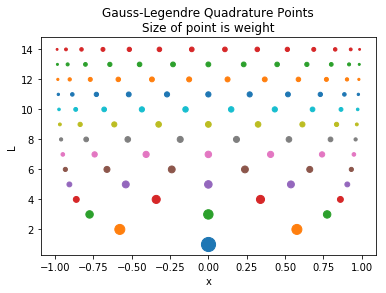

In [42]:
L = np.arange(1,15)
f = lambda x: x
for l in L:
    quad_est, weights, xs = GLQuad(f,l,dataReturn=True)
    levels = weights*0 + l
    plt.scatter(xs, levels, s=weights*100)
plt.xlabel("x")
plt.ylabel("L")
plt.title("Gauss-Legendre Quadrature Points\nSize of point is weight")
plt.show()

Each *row* in the plot above corresponds to a different $L$ value. The rows are colored to guide your eyes. The center of each dot shows the node location. The size of the circle indicates the weight for each node.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Write a few sentences to describe the two trends in the plot above.
</div>

**Home Activity Discussion**:

### 12c-v. Polynomial Example

As a simple demonstration of the Gauss-Legendre quadrature, let's show that it integrates polynomials of degree $2L-1$ exactly.  Consider the integral
$$\int\limits_{-1}^1 (x+1)^{2L-1}\,dx = \frac{2^{2 L-1}}{L}.$$

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Find a partner. Flip an imaginary coin to decide who is partner "A". First, partner "A" explains the code below. Then partner "B" explains the output. Why does this example show the power of Gauss-Legendre quadrature?
</div>

In [43]:
L = np.arange(1,12)
for l in L:
    
    # Create f
    f = lambda x: (x+1)**(2*l-1)
    
    # Evaluate exact (analytic) solution
    integral = 2**(2*l - 1)/l
    
    # Evaluate quadrature rule
    GLintegral = GLQuad(f,l)
    
    # Print results
    print("\nL =", l,"\t Estimate is",GLintegral,
          "Exact value is",integral, 
          "\nAbs. Relative Error is", np.abs(GLintegral-integral)/integral)


L = 1 	 Estimate is 2.0 Exact value is 2.0 
Abs. Relative Error is 0.0

L = 2 	 Estimate is 3.9999999999999996 Exact value is 4.0 
Abs. Relative Error is 1.1102230246251565e-16

L = 3 	 Estimate is 10.666666666666668 Exact value is 10.666666666666666 
Abs. Relative Error is 1.6653345369377348e-16

L = 4 	 Estimate is 31.99999999999999 Exact value is 32.0 
Abs. Relative Error is 3.3306690738754696e-16

L = 5 	 Estimate is 102.39999999999995 Exact value is 102.4 
Abs. Relative Error is 5.551115123125783e-16

L = 6 	 Estimate is 341.33333333333337 Exact value is 341.3333333333333 
Abs. Relative Error is 1.6653345369377348e-16

L = 7 	 Estimate is 1170.2857142857135 Exact value is 1170.2857142857142 
Abs. Relative Error is 5.828670879282072e-16

L = 8 	 Estimate is 4096.000000000003 Exact value is 4096.0 
Abs. Relative Error is 6.661338147750939e-16

L = 9 	 Estimate is 14563.555555555577 Exact value is 14563.555555555555 
Abs. Relative Error is 1.4988010832439613e-15

L = 10 	 Estimate i

### 12c-vi. Sine Example Revisited

Let's see how it performs on the sine example, which is not polynomial:
$$\int_{0}^\pi \sin(x)\,dx = 2$$

Before proceeding, we need to transform (scale) the bounds. Here is a general function:

In [44]:
def generalGL(f,a,b,L):
    """Compute the Gauss-Legendre Quadrature estimate 
    of the integral of f(x) from a to b
    Inputs:
    f:   name of function to integrate
    a:   lower bound of integral
    b:   upper bound of integral
    L:   Order of integration rule (8 or less)
    Returns:
    G-L Quadrature estimate"""
    assert(L>=1)
    #define a re-scaled f
    f_rescaled = lambda  z: f(0.5*(b-a)*z + 0.5*(a+b))
    integral = GLQuad(f_rescaled,L)
    return integral*(b-a)*0.5

We can now proceed with the example.

L = 1 Estimate is 3.141592653589793 Exact value is 2
L = 2 Estimate is 1.9358195746511373 Exact value is 2
L = 3 Estimate is 2.0013889136077436 Exact value is 2
L = 4 Estimate is 1.999984228457722 Exact value is 2
L = 5 Estimate is 2.000000110284472 Exact value is 2
L = 6 Estimate is 1.9999999994772704 Exact value is 2
L = 7 Estimate is 2.0000000000017906 Exact value is 2
L = 8 Estimate is 1.9999999999999951 Exact value is 2
L = 9 Estimate is 1.9999999999999998 Exact value is 2
L = 10 Estimate is 2.0000000000000004 Exact value is 2
L = 11 Estimate is 2.0000000000000013 Exact value is 2
L = 12 Estimate is 1.9999999999999987 Exact value is 2
L = 13 Estimate is 1.9999999999999998 Exact value is 2
L = 14 Estimate is 1.999999999999999 Exact value is 2


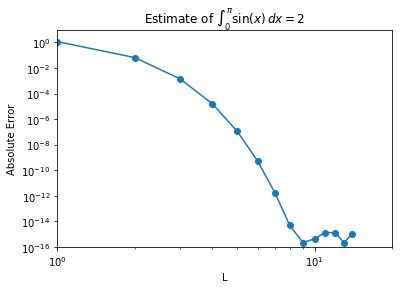

In [45]:
L = np.arange(1,15)
errors = np.zeros(L.size)
f = lambda x: np.sin(x)
integral = 2
for l in L:
    GLintegral = generalGL(f,0,np.pi,l)
    errors[l-1] = np.fabs(GLintegral-integral)
    print("L =",l,"Estimate is",GLintegral,"Exact value is",integral)
plt.loglog(L,errors,'o-')
plt.xlabel("L")
plt.ylabel("Absolute Error")
plt.title("Estimate of $\int_{0}^\pi \sin(x)\,dx = 2$")
plt.axis([1,20,10**-16,10**1])
plt.show()

Notice that we get to machine-precision by evaluating the integral at only 8 points!

This exponential convergence will only be obtained on smooth solutions without singularities in the function or its derivatives.

### 12c-vii. A More Complicated Example

Consider:
$$ \int\limits_0^1 4 \sqrt{1-x^2}\,dx = \pi.$$
This integral has a singularity in its derivative at $x=1$. Gauss-Legendre quadrature will not have exponential convergence on this function.

L = 1 Estimate is 3.4641016151377544 Exact value is 3.141592653589793
L = 2 Estimate is 3.184452077509094 Exact value is 3.141592653589793
L = 3 Estimate is 3.156072695039818 Exact value is 3.141592653589793
L = 4 Estimate is 3.1482294686216954 Exact value is 3.141592653589793
L = 5 Estimate is 3.1451817756693496 Exact value is 3.141592653589793
L = 6 Estimate is 3.1437514508015596 Exact value is 3.141592653589793
L = 7 Estimate is 3.1429916780932854 Exact value is 3.141592653589793
L = 8 Estimate is 3.1425508648538196 Exact value is 3.141592653589793
L = 9 Estimate is 3.1422775824170497 Exact value is 3.141592653589793
L = 10 Estimate is 3.1420991700052934 Exact value is 3.141592653589793
L = 11 Estimate is 3.1419777569660723 Exact value is 3.141592653589793
L = 12 Estimate is 3.141892268737024 Exact value is 3.141592653589793
L = 13 Estimate is 3.141830335674392 Exact value is 3.141592653589793
L = 14 Estimate is 3.1417843690029263 Exact value is 3.141592653589793
L = 15 Estimate is 

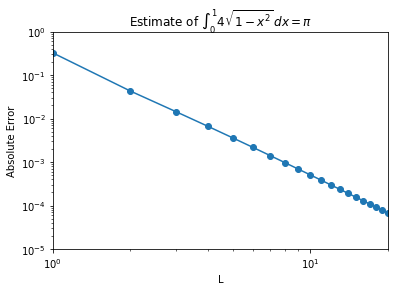

Slope of line from L = 8 to 11 is -2.848973886563485


In [46]:
L = np.arange(1,40)
errors = np.zeros(L.size)
f = lambda x: 4.0*np.sqrt(1-x**2)
integral = np.pi
for l in L:
    GLintegral = generalGL(f,0,1,l)
    errors[l-1] = np.fabs(GLintegral-integral)
    print("L =",l,"Estimate is",GLintegral,"Exact value is",integral)
plt.loglog(L,errors,'o-')
plt.xlabel("L")
plt.ylabel("Absolute Error")
plt.title("Estimate of $ \int_0^1 4\sqrt{1-x^2} \, dx = \pi$")
plt.axis([1,20,10**-5,10**0])
plt.show()
slope = (np.log(errors[-1]) - np.log(errors[0]))/(np.log(L[-1]) - np.log(L[0]) )
print("Slope of line from L = 8 to 11 is",slope)

There is a big difference between exponential convergence we saw in the integral of the sine function and the polynomial convergence in this problem. Even at a high rate of convergence (order 2.8), the error converges slowly in that we are still only accurate to 3 digits at $L=13.$

## 11d. Adaptive Methods Overcome Certain Limitations

The example

$$ \int\limits_0^1 4 \sqrt{1-x^2}\,dx = \pi$$

is problematic for both **Newton-Cotes** and **Gauss quadrature** methods because the derivative is singular at $x=1$. Adaptive variations of both these numeric integration techniques are used in practice to address challenges like this. See Chapters 15 and 16 in McClarren for additional details on adaptive methods (optional - if you want to learn more).

### Scipy Documentation

In [47]:
help(integrate)

Help on package scipy.integrate in scipy:

NAME
    scipy.integrate

DESCRIPTION
    Integration and ODEs (:mod:`scipy.integrate`)
    
    .. currentmodule:: scipy.integrate
    
    Integrating functions, given function object
    
    .. autosummary::
       :toctree: generated/
    
       quad          -- General purpose integration
       dblquad       -- General purpose double integration
       tplquad       -- General purpose triple integration
       nquad         -- General purpose n-dimensional integration
       fixed_quad    -- Integrate func(x) using Gaussian quadrature of order n
       quadrature    -- Integrate with given tolerance using Gaussian quadrature
       romberg       -- Integrate func using Romberg integration
       quad_explain  -- Print information for use of quad
       newton_cotes  -- Weights and error coefficient for Newton-Cotes integration
       IntegrationWarning -- Warning on issues during integration
    
    Integrating functions, given fixed 

In [48]:
help(integrate.quad)

Help on function quad in module scipy.integrate.quadpack:

quad(func, a, b, args=(), full_output=0, epsabs=1.49e-08, epsrel=1.49e-08, limit=50, points=None, weight=None, wvar=None, wopts=None, maxp1=50, limlst=50)
    Compute a definite integral.
    
    Integrate func from `a` to `b` (possibly infinite interval) using a
    technique from the Fortran library QUADPACK.
    
    Parameters
    ----------
    func : {function, scipy.LowLevelCallable}
        A Python function or method to integrate.  If `func` takes many
        arguments, it is integrated along the axis corresponding to the
        first argument.
    
        If the user desires improved integration performance, then `f` may
        be a `scipy.LowLevelCallable` with one of the signatures::
    
            double func(double x)
            double func(double x, void *user_data)
            double func(int n, double *xx)
            double func(int n, double *xx, void *user_data)
    
        The ``user_data`` is the 

In [49]:
f = lambda x: 4.0*np.sqrt(1-x**2)
y, abserr, infodict = integrate.quad(f, 0, 1,full_output=1)
print("Integral:",y)
print("Absolute Error:",abserr)
print("More Info:\n",infodict)

Integral: 3.1415926535897922
Absolute Error: 3.533564552071766e-10
More Info:
 {'neval': 231, 'last': 6, 'iord': array([          1,           2,           3,           4,           5,
                 6,  1148189337,  1071652961, -2009300619,  1071649954,
        -162082469,  1071648331,   937269587,  1071647357,    84173811,
        1071646726,  -308076965,  1071646293,   784824636,  1071645985,
        -338707003,  1071645756,  1757177181,  1071645583,  1870461209,
        1071645448,  1611076895,  1071645341,   120791678,  1071645255,
        1611924578,  1071645184,  -726735059,  1071645125,  -955754064,
        1071645076,  1155439880,  1071645035,  -714338772,  1071644999,
        1468218800,  1071644969,  -365615961,  1071644942,  -596945484,
        1071644919, -1590613515,  1071644899,  -952900605,  1071644881],
      dtype=int32), 'alist': array([ 9.68750000e-001,  0.00000000e+000,  5.00000000e-001,
        7.50000000e-001,  8.75000000e-001,  9.37500000e-001,
        9.29453

## 11e. Appliction: Inertial Navigation Systems

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Read through this problem description BEFORE attending class.
</div>

Inertial navigation systems (INS), which were originally developed to control the trajectory of rockets, have a long history.  According to an interesting article on Wikipedia, the early gyroscopic attitude control system developed by Robert Goddard (considered the father of American rocketry, and for whom Goddard Space Flight Center is named) was extended by Werner von Braun to include an accelerometer for control of the German V2 rocket used in World War II.  Basically, two gyroscopes and an accelerometer were connected through an analog computer to rudders in the rocket exhaust to keep the rocket on its desired trajectory.  Technology has improved quite a bit since then!  In addition to vastly more sophisticated systems for rockets and satellites (think about the precision necessary to actually land a Falcon 9 booster), INS is used for “dead reckoning” in submarines, aircraft, and really anything that moves: possibly even the iPhone in your pocket.  In this project you will analyze a set of data collected by Professor Dowling in an AP Physics extra credit project back when he was a teenager to determine the height between floors of a building.  It reveals both the advantages and disadvantages of the technique: the ability to infer changes in position from acceleration, and the difficulty associated with accumulated errors.

For his high school project, Professor Dowling took a small portable scale, a large brick, and a camera onto an elevator in the ASU Life Sciences Building (then the tallest building at ASU) and rode the elevator from the top of the building (5th floor) to the sub-basement (e.g., -2nd floor).  Thus, the elevator traveled a total of six floors before stopping.  Using the video camera and frame by frame analysis he determined a time series of when the scale reading changed (thus the times are not equally spaced). This data is shown below.

| Time | Weight |
|-|-|
| 2.40 | 2.765 | 
| 3.13 | 2.770 | 
| 5.27 | 2.765 | 
| 5.93 | 2.665 |
| 6.67 | 2.575 |
| 8.00 | 2.605 |
| 8.73 | 2.755 |
| 9.47 | 2.760 |
| 10.13 | 2.765 |
| 10.93 | 2.775 |
| 11.53 | 2.765 |
| 12.27 | 2.760 |
| 13.00 | 2.765 |
| 13.67 | 2.770 |
| 14.40 | 2.765 |
| 15.07 | 2.770 |
| 16.53 | 2.765 |
| 17.20 | 2.770 |
| 17.93 | 2.765 |
| 18.60 | 2.770 |
| 19.33 | 2.765 |
| 20.73 | 2.830 |
| 21.40 | 2.890 |
| 21.47 | 3.000 |
| 22.20 | 3.005 |
| 22.93 | 2.815 |
| 23.60 | 2.810 |
| 24.27 | 2.770 |
| 25.07 | 2.765 |
| 25.13 | 2.765 |



According to his report, the first four readings were prior to the elevator door shutting, thus the velocity (and acceleration) over that period should be zero.  The elevator door shut at 5.27s, and then the apparent weight of the brick starts to drop as the elevator accelerates downwards.  At the bottom the weight increases above its zero acceleration value, and then the elevator comes to rest again.  Your goal is to use this data to accurately determine the average height of a floor in the ASU building.

### 11e-i. Preliminary Analysis

We will start by plotting the raw data in Python.

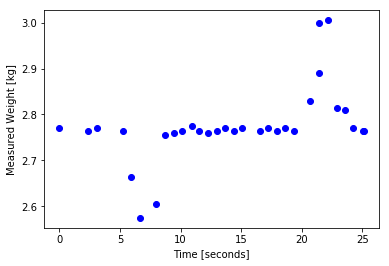

In [50]:
time = np.array([0.0,2.40,3.13,5.27,5.93,6.67,8.00,8.73,9.47,10.13,10.93,11.53,12.27,13.00,13.67,14.40,15.07,16.53,17.20,17.93,18.60,19.33,20.73,21.40,21.47,22.20,22.93,23.60,24.27,25.07,25.13])
weight = np.array([2.770,2.765,2.770,2.765,2.665,2.575,2.605,2.755,2.760,2.765,2.775,2.765,2.760,2.765,2.770,2.765,2.770,2.765,2.770,2.765,2.770,2.765,2.830,2.890,3.000,3.005,2.815,2.810,2.770,2.765,2.765])
plt.plot(time,weight,marker='o',linestyle='',color='blue')
plt.xlabel('Time [seconds]')
plt.ylabel('Measured Weight [kg]')
plt.show()

The measured weight decreases and then increases. Which conclusion can you draw from this data and your physical intuition?
1. The elevator traveled upward.
2. The elevator traveled downward.
3. Cannot tell from the data alone.
4. The elevator traveled updward and then downward, returning to its initial location.
3. The elevator traveled downward and then upward, returning to its initial location.

<div style="background-color: rgba(0,255,0,0.05) ; padding: 10px; border: 1px solid darkgreen;"> 
<b>Home Activity</b>: Store your answer as an integer in <tt>ans_elevator</tt>.
</div>

In [51]:
### BEGIN SOLUTION
ans_elevator = 2
### END SOLUTION

In [52]:
### BEGIN HIDDEN TESTS
secret_elevator = 2

assert type(ans_elevator) is int, "Your answer should be an integer."

assert ans_elevator == secret_elevator, "Try again. Do you feel heavier or lighter when an elevator starts to go down."
### END HIDDEN TESTS

We will now remove the data prior to 5.27s (but keep it for later) and subtract 5.27 from the remaining times so that your new time vector starts at zero.

In [53]:
# "clipped" time
c_time = time[3:].copy()

# "clipped" weight
c_weight = weight[3:].copy()

# subtract 5.27 seconds. Now adj_time[0] is 0.0
adj_time = c_time - 5.27

print("adj_time:",adj_time)
print("\nc_weight:",c_weight)

adj_time: [ 0.    0.66  1.4   2.73  3.46  4.2   4.86  5.66  6.26  7.    7.73  8.4
  9.13  9.8  11.26 11.93 12.66 13.33 14.06 15.46 16.13 16.2  16.93 17.66
 18.33 19.   19.8  19.86]

c_weight: [2.765 2.665 2.575 2.605 2.755 2.76  2.765 2.775 2.765 2.76  2.765 2.77
 2.765 2.77  2.765 2.77  2.765 2.77  2.765 2.83  2.89  3.    3.005 2.815
 2.81  2.77  2.765 2.765]


### 11e-ii. Free Body Diagram & Acceleration

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the following with a partner.
</div>

1. Draw a free body diagram.
2. Apply Newton’s Laws of Motion.
3. Using algebra, obtain a formula to calculate acceleration using the rest $(m_0)$ and moving ($m_t$) weight of the brick.

Then using the initial weight measured at 5.27s (elevator closing weight) calculate the acceleration at each measurement time and plot it up.  Use the local g acceleration for Tempe, AZ (a Google search on “acceleration gravity Tempe Arizona” brings up a fun little Wolfram Alpha widget which yields local g for everywhere in the world – because the world is a slightly oblate spheroid, gravity is higher in northern latitudes).

We will now implement our formula to compute the acceleration at each timepoint.

<div style="background-color: rgba(0,0,255,0.05) ; padding: 10px; border: 1px solid darkblue;"> 
<b>Class Activity</b>: Do the following with a partner.
</div>

1. Use the initial weight measured at 5.27s (elevator closing weight) as $m_0$. Also use $g$ = = 9.80561 m/s$^2$, which is the local gravity acceleration for Tempe, AZ.
2. Calculate the acceleration of the elevator for each weight measurement.
3. Plot acceleration versus time.

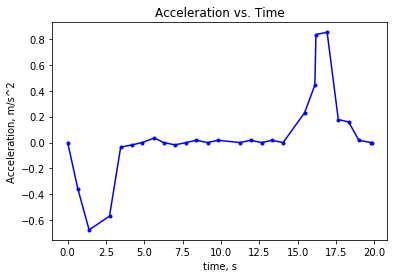

In [54]:
### BEGIN SOLUTION
w0 = c_weight[0]

# g = 9.807 # Acceleration
g = 9.80561

acc = g*(c_weight - w0)/w0

plt.plot(adj_time,acc,marker='.',linestyle='-',color='blue')
plt.title("Acceleration vs. Time")
plt.xlabel("time, s")
plt.ylabel("Acceleration, m/s^2")
plt.show()
### END SOLUTION

### 11e-iii. Velocity

Calculate the velocity at each measurement. Remember, the velocity is just the integral of the acceleration. (Again, recall Physics 1.) Because each data point is given where the scale reading changes, an assumption is that the acceleration is constant prior to the next reading.  Thus it is appropriate to use a left edge Riemann sum to get the velocity at all subsequent times (the initial velocity is zero).  This is easiest to do with the **np.cumsum** command.  Do this, and plot up the velocity as a function of time. *Hint*: Assume initial velocity is zero.

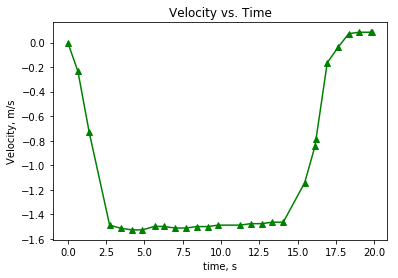

In [55]:
### BEGIN SOLUTION
v0 = 0
N = len(adj_time)-1
t_diff = adj_time[1:] - adj_time[0:N]

# original (off by 1 error)
prod = t_diff*acc[1:]

# corrected?
# prod = t_diff*acc[0:-1]

RS = np.cumsum(prod)

vel = np.asarray([v0,*RS])

plt.plot(adj_time,vel,marker='^',color='green',linestyle='-')
plt.title("Velocity vs. Time")
plt.xlabel("time, s")
plt.ylabel("Velocity, m/s")
plt.show()
### END SOLUTION

### 11e-iv. Position

Finally, calculate the position at each measurement.  The position is the integral of the velocity.  If the acceleration were constant between each data point, then the velocity will be linear in time between each data point.  This suggests that the best way to get the change of position would be to use the trapezoidal rule.  Again taking the initial height to be a reference value of zero, do this integration and plot up the height vs. time. Use **np.cumsum** again. Report the negative of the final height, and divide it by 6 to get the average height of the floors. *Hint*: Assume initial velocity and initial height are both zero.

3.6146661293625804 m


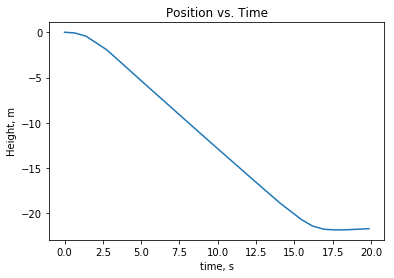

In [56]:
### BEGIN SOLUTION
h0 = 0
Nt = len(adj_time)-1
Nv = len(vel)-1
t_diff = adj_time[1:] - adj_time[0:Nt]
vel_sum = vel[1:] + vel[0:Nv]
prod = 0.5*(vel_sum*t_diff)
TR = np.cumsum(prod)

h = [v0,*TR]

plt.plot(adj_time,h)
plt.title("Position vs. Time")
plt.xlabel("time, s")
plt.ylabel("Height, m")

ave_floor_h = -1*(h[-1])/6
print(ave_floor_h,"m")

### END SOLUTION